# Generate ACFs with various oscillation parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from datetime import datetime
import celerite
from celerite import terms
from scipy.optimize import minimize
from scipy.signal import find_peaks
from astropy.timeseries import LombScargle
from datetime import timedelta, date
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

plt.rcParams.update({'font.size': 18})

In [2]:
import jax
import jax.numpy as jnp
from tinygp import kernels, GaussianProcess
import tinygp

jax.config.update("jax_enable_x64", True)

2022-11-08 15:16:04.013561: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-08 15:16:04.233329: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/julia-1.8.1/julia-1.8.1/lib:/storage/icds/RISE/sw8/anaconda/anaconda3/lib
2022-11-08 15:16:04.247281: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /storage/icds/RISE/sw8/jul

In [3]:
uHz_conv = 1e-6 * 60

def gaussian_2(x, amp, mu, sig):
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) 


In [4]:
amp0, mu0, sig0 = np.array([ 5.46875972e-03,  3.08082489e+03, 3.05370933e+02])    
amp0 *= 6e1
nu_max0 = mu0
delta_nu0 = 135
epsilon0 = 0
Q0 = 4e2
N0 = 19 # 25*135/2=1620

def generate_acf(nu_max, delta_nu, epsilon, Q, amp, sig, N, filename=''):

    x = np.linspace(0, 700, 3000)

    kernel = 0  

    for i in range(int(N)):
        omega = 2*np.pi*(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon)*uHz_conv
        sigma = gaussian_2(nu_max + (-(N-1)/2+i)*delta_nu/2 + epsilon, amp, nu_max, sig) 
        kernel += tinygp.kernels.quasisep.SHO(omega, Q, sigma)
        # print(2*np.pi/omega)
        # print(sigma)

    # gp = GaussianProcess(kernel, X, diag=jnp.float64(diag))
    gp = GaussianProcess(kernel, x)


    Nr = 500
    y = gp.sample(jax.random.PRNGKey(4), shape=(Nr,))


    ACF = np.zeros((Nr, len(x)))
    for i in range(Nr):
        ACF[i,:] = sm.tsa.acovf(y[i,:], fft=True)/(1-x/max(x*1.001))


    fig = plt.figure(figsize=(16, 6))
    # plt.plot(x, ACF.T, 'k', alpha=0.05)
    plt.plot(x, np.mean(ACF, axis=0), lw=2, label='mean')
    plt.plot(x, np.median(ACF, axis=0), lw=2, alpha=0.9, label='median')
    plt.title('ACF for simulated data')
    plt.xlim([0,600])
    # plt.ylim([-2,2.0])
    plt.xlabel(r'$\Delta t$ [minutes]')
    plt.ylabel(r'Covariance [m$^2$/s$^2$]')
    plt.legend()

    textstr = '\n'.join((
        r'$\nu_{max}=%.2f$' % nu_max,
        r'$\Delta\nu=%.2f$' % delta_nu,
        r'$\epsilon=%.2f$' % epsilon,
        r'$Q$=%d' % Q,
        r'$S_{0,0}=%.4f$' % amp,
        r'$\sigma=%.0f$' % sig,
        r'$N=%d$' % N
    ))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(350, -0.1, textstr, fontsize=16,
            verticalalignment='top', bbox=props)
    if filename == '':
        plt.show()
    else:
        plt.savefig(filename)
    plt.close()




In [ ]:
for nu_max_i in np.linspace(2500, 3500, 30):
    print(nu_max_i)
    generate_acf(nu_max=nu_max_i, delta_nu=delta_nu0, epsilon=epsilon0, Q=Q0, amp=amp0, sig=sig0, N=N0, filename='./Figure/nu_max/nu_max=%.0f.png'%nu_max_i)

2500.0
2534.4827586206898
2568.9655172413795
2603.448275862069
2637.9310344827586
2672.4137931034484
2706.896551724138
2741.3793103448274
2775.862068965517
2810.344827586207
2844.8275862068967
2879.310344827586
2913.793103448276
2948.2758620689656
2982.7586206896553
3017.241379310345
3051.7241379310344


In [8]:
# generate_acf(nu_max=nu_max0, delta_nu=delta_nu0, epsilon=epsilon0, Q=Q0, amp=amp0, sig=sig0, N=N0, filename='./Figure/test.png')

In [20]:
for delta_nu_i in np.linspace(100, 170, 30):
    print(delta_nu_i)
    generate_acf(nu_max=nu_max0,
				 delta_nu=delta_nu_i,
				 epsilon=epsilon0,
				 Q=Q0,
				 amp=amp0,
				 sig=sig0,
				 N=N0,
				 filename='./Figure/delta_nu/delta_nu=%.0f.png'%delta_nu_i)
    
img_array = []
for filename in glob.glob('./Figure/delta_nu/*.png'):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('./Video/delta_nu.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()    

100.0
102.41379310344827
104.82758620689656
107.24137931034483
109.65517241379311
112.06896551724138
114.48275862068965
116.89655172413794
119.3103448275862
121.72413793103448
124.13793103448276
126.55172413793103
128.9655172413793
131.3793103448276
133.79310344827587
136.20689655172413
138.6206896551724
141.0344827586207
143.44827586206895
145.86206896551724
148.27586206896552
150.68965517241378
153.10344827586206
155.51724137931035
157.9310344827586
160.3448275862069
162.75862068965517
165.17241379310343
167.58620689655172
170.0


OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


0.009732657795155806
0.017070901034184953
0.028514244625257465
0.04535735628818486
0.0687090637681386
0.09911987920425651
0.13617203661431207
0.17815398337889624
0.22196452877492187
0.26336135786308595
0.29757809812482694
0.32020662301619385
0.3281255832
0.32020662301619385
0.29757809812482694
0.26336135786308595
0.22196452877492187
0.17815398337889624
0.13617203661431207
0.09911987920425651
0.0687090637681386
0.04535735628818486
0.028514244625257465
0.017070901034184953
0.009732657795155806


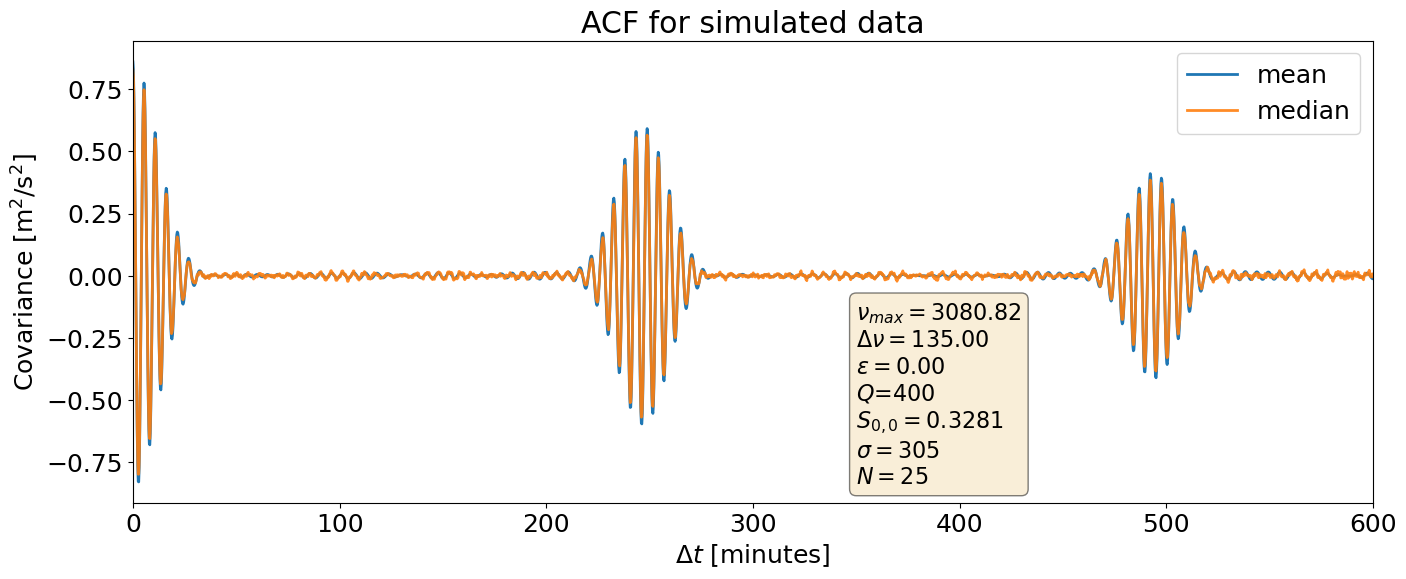

In [6]:
generate_acf(nu_max=nu_max0,
             delta_nu=delta_nu0,
             epsilon=epsilon0,
             Q=Q0,
             amp=amp0,
             sig=sig0,
             N=N0)

# Part II